# Binary Task SVM Notebook

### Contains Code for Binary task SVM Model creation, training and validation(hyperparameter tuning)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle as pkl
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function (TO DO: include exception if tqdm not imported )
from tqdm import tqdm

#Importing libraries used for SVM classification and model assessment
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset, dataset_PCA, Tuned_SVM_train, SVM_predictions


Using TensorFlow backend.


# 1. Loading Dataset and doing final preprocessing
### We Load the preprocessed data and carry out PCA on the image array here for the binary training and test data
## 1.1 Loading Datasets

In [2]:
#Calls load_dataset function from "functions.ipynb" which loads the X data and Y label datasets for binary task from the inputted file paths
#It prints the loaded array shapes to verify it has completed properly
X, Y = load_dataset('.\dataset\Image_DF_Flat.pkl', './dataset/Y_Binary_label.pkl')

Datasets successfully loaded with shapes:
Y Shape:
(3000,)
X Shape:
(3000, 784)


##### We can do PCA for the images but must be done separately for binary and multiclass task as the data must be split first.<br/> This is because we must do PCA on the training data only (fit and transform it) and then only use the transform on the test data to prevent bias<br/> We select 400 components as it provides around 96% explained variance as shown previously.

## 1.2 Splitting data in to training and testing sets

In [3]:
# Split the data into training and testing(70% training and 30% testing data)
# The training set will be used for training and validation
# Validation in terms of using it to assess and tune the hyperparameter values using Grid Search as well as cross validation on the hyperparameter values
# Setting random_state to 42 keeps the same random generator seed to be used.
# This maintains the split used across code executions so results obtained will be the same for other users
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7, random_state = 42)

#To verify split data is the same regardless of number of executions
#print(xTrain)

#Rescaling the dataframe as the pixel values range from 0 to 255
#We want it to be between 0 to 1 for easier classification for SVM
xTrain_Scaled = xTrain/255
xTest_Scaled = xTest/255

#### 1.2.1 Displaying label distribution<br/> We show the the number of samples in each class label 

In [4]:
#Number of Samples per class in training data
print("Training dataset number of samples per class:")
print(yTrain.value_counts())

#Number of Samples per class in test data
print("Test dataset number of samples per class:")
print(yTest.value_counts())

#This shows that there is a very large imbalance in the dataset between the binary labels (Tumor and no tumor)

Training dataset number of samples per class:
1.0    1780
0.0     320
Name: MRI_Binary_Label, dtype: int64
Test dataset number of samples per class:
1.0    766
0.0    134
Name: MRI_Binary_Label, dtype: int64


## 1.3 PCA

In [5]:
#Initialising PCA with 400 components determined in preprocessing notebook
#Calls the dataset_PCA function defined in "functions.ipynb" to carry out PCA
#Input arguements are number of components, xTrain data and xTest data
#We put in the scaled X train and test data
xTrain_PCA, xTest_transformed = dataset_PCA(400, xTrain_Scaled, xTest_Scaled)

#Function also returns the resultant explained variance percentage when we use 400 components.
#Verified that explained variance using 400 components is ~96.498%

PCA conducted with 400 components.
The percentage of Explained Variance of the dataset from PCA is: 96.4978759418244


# 2. Model Building
#### This section describes the training and testing of the Binary SVM models.
## 2.1 SVM without tuning
### 2.1.1 Training<br/> We first train SVM without hyperparameter tuning to assess the performance of the model with the training and test data

In [6]:
#Training model using SVC without hyperparameter tuning
#SVC allows automatic scaling of weights to counter imbalanced datasets. This is done by setting class_weight to 'balanced'
#Default value for C is 1
#Default value for gamma is = 1 / (n_features * X.var())
binary_SVM_untuned = SVC(probability = True)
binary_SVM_untuned.fit(xTrain_PCA, yTrain.values.ravel())

SVC(probability=True)

### 2.1.2 Binary Untuned SVM Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [7]:
#Calls SVM_predictions function from "functions.ipynb" to carry out the predictions on the sample test set using the base SVM model we made.
#It prints out the classification report of the predictions as well as the confusion matrix
#Also Returns the predictions of each sample
Binary_SVM_untuned_pred = SVM_predictions(binary_SVM_untuned, xTest_transformed, yTest)

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.95      0.57      0.71       134
         1.0       0.93      0.99      0.96       766

    accuracy                           0.93       900
   macro avg       0.94      0.78      0.84       900
weighted avg       0.93      0.93      0.92       900

The confusion matrix is:
[[ 76  58]
 [  4 762]]


## 2.2 SVM with validation

### 2.2.1 Training<br/> 
#### We now use SVM again but with validation, tuning of the hyperparameter values and cross validation<br/> This is done using an exhaustive Gridsearch of the parameter values given along with cross validation using GridsearchCV <br/> After model is trained, we obtain the best parameters found by the gridsearch

In [8]:
#Using SVM but this time with gridsearch to tune hyperparameter

#Define the parameter values we want to be tested
#We test various values of:
# C
# gamma
# Type of Kernel to use
# The values are arranged in logarithmic increments
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','sigmoid']
}

In [9]:
#Calls Tuned_SVM_train from "functions.ipynb" to conduct training and tuning of SVM model using gridsearch
#Full details on the input arguements listed in the functions notebook

#Function prints the resultant best hyperparameters found and new details of the model
#Returns the tuned model
Binary_SVM_Tuned = Tuned_SVM_train(param_grid, 10, xTrain_PCA, yTrain, True)

#est time on last run = 16mins

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Tuned SVM Model successfully trained and tuned
The best hyperparameters found by gridsearch are:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
The new model created after hyperparameter tuning is:
SVC(C=100, class_weight='balanced', gamma=0.01, probability=True)


### 2.2.2 Binary Tuned SVM Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [10]:
#Calls SVM_predictions function from "functions.ipynb"
#This time we are doing predictions with the tuned SVM model
Binary_SVM_Tuned_pred = SVM_predictions(Binary_SVM_Tuned, xTest_transformed, yTest)

#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78       134
         1.0       0.95      0.98      0.97       766

    accuracy                           0.94       900
   macro avg       0.91      0.84      0.87       900
weighted avg       0.94      0.94      0.94       900

The confusion matrix is:
[[ 95  39]
 [ 15 751]]


## 2.3 Comparing untuned and tuned SVM performance
##### We utilise the ROC and AUC metrics to assess and compare the difference in performance of untuned and tuned SVM<br/> We show the ROC curve as well to visualise the difference in model performance. 
##### 2.3.1 TPR and AUC metric from binary predictions with 3 point ROC curve demonstration

In [24]:
#Directly calculating AUC metric for comparison between tuned and untuned binary SVM from the discrete predictions given by SVM model
#roc_curve returns the FPR, TPR and threshold values which are also used for plotting the ROC curve

#Untuned SVM
Untuned_TNR = 762 / (762 + 58) #True negative rate for untuned SVM based on confusion matrix
FPR_Base_SVM, TPR_Base_SVM, Base_SVM_thres = roc_curve(yTest, Binary_SVM_untuned_pred)
print("The following are the metrics for unTuned SVM:")
print("The True Positive Rate: ", print(TPR_Base_SVM))
print("True Negative Rate: ", Untuned_TNR)
print('The AUC score for Untuned SVM: ', roc_auc_score(yTest, Binary_SVM_untuned_pred))
print("")

#Tuned SVM
Tuned_TNR = 751 / (751 + 39) #True negative rate for tuned SVM based on confusion matrix
FPR_Tuned_SVM, TPR_Tuned_SVM, Tuned_SVM_thres = roc_curve(yTest, Binary_SVM_Tuned_pred)
print("The following are the metrics for Tuned SVM:")
print("The True Positive Rate: ", print(TPR_Tuned_SVM))
print("True Negative Rate: ", Tuned_TNR)
print('The AUC score for Tuned SVM: ', roc_auc_score(yTest, Binary_SVM_Tuned_pred))

roc_auc_score for Untuned SVM:  0.7809711234947977
roc_auc_score for Tuned SVM:  0.8446864892248938


In [ ]:
#The resultant ROC curves produced by the base predictions for the SVM models gives a 3 points ROC curve as the SVM output is discrete.
plt.subplots(1, figsize=(10,10))
plt.grid()

#This plot is the base SVM model
plt.plot(FPR_Base_SVM, TPR_Base_SVM, linestyle='-', color='b', marker='o', label ="Untuned SVM")

#This plot is our tuned SVM model
plt.plot(FPR_Tuned_SVM, TPR_Tuned_SVM, linestyle='-', color='r', marker='x', label ="Tuned SVM")

#Optimal Model line
plt.plot([0, 1], ls="--")

#Diagonal Dotted Line
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

#Labels for title and axis
plt.title('Receiver Operating Characteristic - Untuned and Tuned Binary SVM with discrete predictions', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20)

#Saves plot to be used in the report
plt.savefig('./Plots/ROC_Binary_SVM_discrete.jpg', bbox_inches='tight')

#### 2.3.2 Plot ROC curve using decision_function

In [20]:
#Using roc_curve method we obtain the various values pertinent to assessing accuracy for models, we take for both the Untuned and Tuned SVM model predictions
#Following which we also print the area under the ROC curve metric AUC. The higher the value the better the model

#We use predict_proba to obtain probabilities of the output class label for ROC curve plotting for TPR vs FPR
Binary_SVM_untuned_pred_proba = binary_SVM_untuned.decision_function(xTest_transformed)
Binary_SVM_Tuned_pred_proba = Binary_SVM_Tuned.decision_function(xTest_transformed)

In [21]:
#Untuned SVM using decision function to get estimated class probabilities
FPR_Base_SVM_prob, TPR_Base_SVM_prob, Base_SVM_thres_prob = roc_curve(yTest, Binary_SVM_untuned_pred_proba)
print('roc_auc_score for Untuned SVM: ', roc_auc_score(yTest, Binary_SVM_untuned_pred_proba))

#Tuned SVM using decision function to get estimated class probabilities
FPR_Tuned_SVM_prob, TPR_Tuned_SVM_prob, Tuned_SVM_thres_prob = roc_curve(yTest, Binary_SVM_Tuned_pred_proba)
print('roc_auc_score for Tuned SVM: ', roc_auc_score(yTest, Binary_SVM_Tuned_pred_proba))


roc_auc_score for Untuned SVM:  0.9637290051050232
roc_auc_score for Tuned SVM:  0.9264350570905264


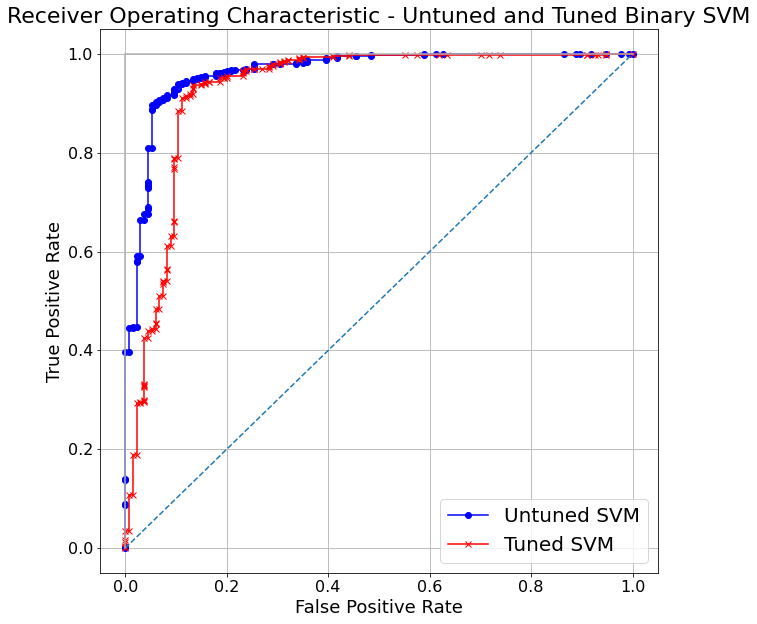

In [22]:
#We can visualise the ROC curve to see the two ROC curves for the untuned and tuned model.

plt.subplots(1, figsize=(10,10))
plt.grid()

#This plot is the base SVM model
plt.plot(FPR_Base_SVM_prob, TPR_Base_SVM_prob, linestyle='-', color='b', marker='o', label ="Untuned SVM")

#This plot is our tuned SVM model
plt.plot(FPR_Tuned_SVM_prob, TPR_Tuned_SVM_prob, linestyle='-', color='r', marker='x', label ="Tuned SVM")

#Optimal Model line
plt.plot([0, 1], ls="--")

#Diagonal Dotted Line
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

#Labels for title and axis
plt.title('Receiver Operating Characteristic - Untuned and Tuned Binary SVM', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.legend(fontsize=20)

#Saves plot to be used in the report
plt.savefig('./Plots/ROC_Binary_SVM_probability.jpg', bbox_inches='tight')

## 2.4 Saving Trained models
### We save both trained SVM Models for easy reference and future use in an out of sample test dataset

In [23]:
#Saving tuned and base SVM models
save_path = "./Models/Binary-Classification"
Tuned_SVM_filename = 'Tuned_SVM_model.sav'
Base_SVM_filename = 'Untuned_SVM_model.sav'

#Using Pickle to save them in the Models folder
pkl.dump(binary_SVM_untuned , open(os.path.join(save_path, Base_SVM_filename), 'wb'))
pkl.dump(Binary_SVM_Tuned, open(os.path.join(save_path, Tuned_SVM_filename), 'wb'))


In [15]:
#Code to test loading of trained tuned SVM model
load_tuned_SVM = pkl.load(open('.\Models\Binary-Classification\Tuned_SVM_model.sav', 'rb'))
#Gets the best parameter values from loaded model
best_param = load_tuned_SVM.best_params_
#Prints out the parameter values
#Output should match earlier .best_params_ output
print(best_param)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
